DEPENDENCIES

In [1]:
# import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
from math import isnan
from matplotlib.animation import FuncAnimation
import scipy.ndimage as ndimage
from matplotlib import animation, rc
import geopandas
from geopandas import GeoDataFrame
import requests
import json
from Resources.config import app_token

IMPORTING POPULATION BY COMMUNITY AREA DATA

In [4]:
pop=pd.read_csv('Resources/Pop-Census-Data-by-Chicago-Community-Area-2017.csv')
pop['Community'] = pop['Community'].str.upper() 
pop2=pop[['Total Population','Community']]
pop2.sort_values(by='Total Population', ascending=False)

,Total Population,Community
0,102584,LAKE VIEW
1,97604,AUSTIN
2,96466,NEAR NORTH SIDE
3,84660,WEST TOWN
4,78037,BELMONT CRAGIN
...,...,...
72,7033,AVALON PARK
73,6565,RIVERDALE
74,5181,OAKLAND
75,3220,FULLER PARK


IMPORTING COMMUNITY AREA DATA

In [6]:
community_area_names_pd=pd.read_csv('Resources/CommAreas_20200108.csv')
comm=community_area_names_pd

IMPORTING 311 - STREET LIGHT OUTAGES DATA

In [7]:
street_light_reports_pd=pd.read_csv('Resources/ServiceRequests_2014_2018.csv')
street=street_light_reports_pd

IMPORTING CRIME DATA

In [8]:
## Source: Crimes - 2001 to present
## https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
url_crime_data = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
date_filter="$WHERE=DATE BETWEEN '2014-01-01' AND '2018-12-31'"
crime_records_limit = 2000000
url_crime_data_with_filter = f"{url_crime_data}?{date_filter}&$limit={crime_records_limit}&$$app_token={app_token}"
crime_data_json = requests.get(url_crime_data_with_filter).json()
crime_data_df = pd.DataFrame.from_records(crime_data_json)
crime=crime_data_df

crime = crime.rename(columns={"date": "Date"
                           , "primary_type": "Primary Type"
                           , "description": "Description"
                           , "community_area": "Community Area"
                           , "longitude": "Longitude"
                           , "latitude": "Latitude"
                           , "id": "ID"
                          })
crime['Community Area'] = pd.to_numeric(crime['Community Area'],downcast='integer')
crime['Longitude'] = pd.to_numeric(crime['Longitude'],downcast='integer')
crime['Latitude'] = pd.to_numeric(crime['Latitude'],downcast='integer')

CLEANING AND FILTERING CRIME DATA

In [9]:
#remove the records with zero as the community area
crime=crime.loc[crime['Community Area']!=0]

#creating new columns for Year, Month, and Day
crime['Year'] = pd.DatetimeIndex(crime['Date']).year
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Day'] = pd.DatetimeIndex(crime['Date']).day

#filtering data for everything greater than 2013 and less than 2019
crime=crime.loc[(crime['Year']>2013) & (crime['Year']<2019)]

CLEANING AND FILTERING 311 - STREET LIGHT OUTAGES DATA

In [10]:
#add a year column
street['Year'] = pd.DatetimeIndex(street['Creation Date']).year
street['Month'] = pd.DatetimeIndex(street['Creation Date']).month
street['Day'] = pd.DatetimeIndex(street['Creation Date']).day
street=street.loc[(street['Year']>2013) & (street['Year']<2019)]

#Filtering out null and zero values
street_nonull=street.dropna(subset=['Community Area'])
street_nozero=street_nonull.loc[street_nonull['Community Area']!=0]


MERGING CRIME AND COMMUNITY AREAS DATA

In [11]:
#merge the crime data with the community areas data
crime_comm = pd.merge(crime, comm, left_on="Community Area", right_on='AREA_NUMBE', how="left")


MERGING 311-STREET LIGHT OURAGES AND COMMUNITY AREAS DATA

In [12]:
#merge the street data with the community areas data
street_comm = pd.merge(street_nozero, comm, left_on="Community Area", right_on='AREA_NUMBE', how="left")

CRIME ANALYTICS

In [37]:
#total number of records by Community Area
c_bycomm=crime_comm.groupby(['COMMUNITY'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)
# c_bycomm=c_bycomm.sort_values(by='ID',ascending=False)

#total number of records by Year
c_byyear=crime_comm.groupby(['Year'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of records by year by Month
c_byyear_bymonth=crime_comm.groupby(['Year','Month'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of crimes by crime type
c_bytype=crime_comm.groupby(['Primary Type'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of crime reports by community area by year by month
c_bycomm_byyear=crime_comm.groupby(['COMMUNITY','Year'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of crime reports by community area by year by month
c_bycomm_byyear_bymonth=crime_comm.groupby(['COMMUNITY','Year','Month'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

c_bycomm_byType=crime_comm.groupby(['COMMUNITY','Primary Type'])['ID'].count().reset_index()
c_bycomm_byType=c_bycomm_byType.loc[c_bycomm_byType['COMMUNITY']=='AUSTIN']
c_bycomm_byType=c_bycomm_byType.sort_values(by='ID',ascending=False).head(5)

In [39]:
c_bycomm

,COMMUNITY,ID
5,AUSTIN,83489
47,NEAR NORTH SIDE,54023
41,LOOP,45408
52,NORTH LAWNDALE,44426
65,SOUTH SHORE,43966
...,...,...
30,HEGEWISCH,3023
44,MONTCLARE,2996
24,FOREST GLEN,2528
12,BURNSIDE,1950


In [40]:
c_byyear

,Year,ID
0,2014,275430
2,2016,269258
3,2017,268459
4,2018,267110
1,2015,264304


In [42]:
c_byyear_bymonth.head()

,Year,Month,ID
6,2014,7,26547
7,2014,8,25876
5,2014,6,25429
55,2018,8,25352
54,2018,7,25183


In [44]:
c_bytype.head()

,Primary Type,ID
31,THEFT,309972
2,BATTERY,247584
6,CRIMINAL DAMAGE,144260
1,ASSAULT,92349
17,NARCOTICS,91439


In [46]:
c_bycomm_byType.head(5)

,COMMUNITY,Primary Type,ID
142,AUSTIN,BATTERY,17613
157,AUSTIN,NARCOTICS,12125
170,AUSTIN,THEFT,11441
146,AUSTIN,CRIMINAL DAMAGE,7867
141,AUSTIN,ASSAULT,5902


311-STREET REQUEST ANALYTICS

In [49]:

#Total number of requests by community area
s_bycomm=street_comm.groupby(['COMMUNITY'])['Service Request Number'].count().reset_index()
s_bycomm.head()

#Total number of requests by year
s_byyear=street_comm.groupby(['Year'])['Service Request Number'].count().reset_index()

#Total number of requests by year by month
s_byyear_bymonth=street_comm.groupby(['Year','Month'])['Service Request Number'].count().reset_index()

#Total number of requests by community area by year
s_bycomm_byyear=street_comm.groupby(['COMMUNITY','Year'])['Service Request Number'].count().reset_index()



MERGING CRIME & 311 - STREET LIGHT OUTAGES & POPULATION DATA

In [60]:
bycomm = pd.merge(c_bycomm, s_bycomm, on="COMMUNITY", how="left")
bycomm_pop = pd.merge(bycomm, pop, left_on="COMMUNITY", right_on='Community', how="left")


CLEANING & CREATING A NEW COLUMN IN THE MERGED DATA

In [71]:
bycomm_pop['Total Population']=pd.to_numeric(bycomm_pop['Total Population'].astype(str).str.replace(',',''), errors='coerce')
bycomm_pop['No. of Service Requests to Crime Reports']=bycomm_pop['ID']/bycomm_pop['Service Request Number']


MERGED DATA ANALYTICS

In [72]:
#sorting by the ratio of Service Requests to Crime reports
bycomm_pop=bycomm_pop.sort_values(['No. of Service Requests to Crime Reports'],ascending=False)

byyear = pd.merge(c_byyear, s_byyear, on="Year", how="left")

byyearbymonth = pd.merge(c_byyear_bymonth, s_byyear_bymonth, on=["Year","Month"], how="left")

bycommbyyear = pd.merge(c_bycomm_byyear, s_bycomm_byyear, on=["COMMUNITY","Year"], how="left")
bycommbyyear = pd.merge(bycommbyyear, comm, on=["COMMUNITY"], how="left")

In [73]:
bycomm_pop
# Notes:
# Forest Glen (1:3.73)
# Austin (1:31)
# Loop (1:57)


,COMMUNITY,ID,Service Request Number,Community,Community Area,Total Population,Age 0-2 (Population),Age 3-4 (Population),Age 5 (Population),Age 6-12 (Population),Age 13+ (Population),No. of Service Requests to Crime Reports
2,LOOP,45408,797,LOOP,32.0,32936.0,"1,051",629,260,"1,516","29,480",56.973651
48,OHARE,8907,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.784884
25,ROGERS PARK,19037,407,ROGERS PARK,1.0,53470.0,"2,164","1,166",616,"3,819","45,705",46.773956
1,NEAR NORTH SIDE,54023,1232,NEAR NORTH SIDE,8.0,96466.0,"2,902","1,445",467,"3,092","88,560",43.849838
15,WEST GARFIELD PARK,29120,798,WEST GARFIELD PARK,26.0,20146.0,"1,198","1,068",320,"2,273","15,287",36.491228
...,...,...,...,...,...,...,...,...,...,...,...,...
72,HEGEWISCH,3023,603,HEGEWISCH,55.0,9745.0,483,225,115,961,"7,961",5.013267
76,EDISON PARK,1338,283,EDISON PARK,9.0,10856.0,201,226,38,"1,086","9,305",4.727915
71,MOUNT GREENWOOD,3057,718,MOUNT GREENWOOD,74.0,16878.0,773,574,297,"1,452","13,782",4.257660
66,BEVERLY,4705,1242,BEVERLY,72.0,19969.0,827,582,229,"1,695","16,636",3.788245


LET'S MAKE SOME VISUALS

2528
677


Text(2528, 677, 'FOREST GLEN (Smallest  Service Request to Crime Report Ratio)')

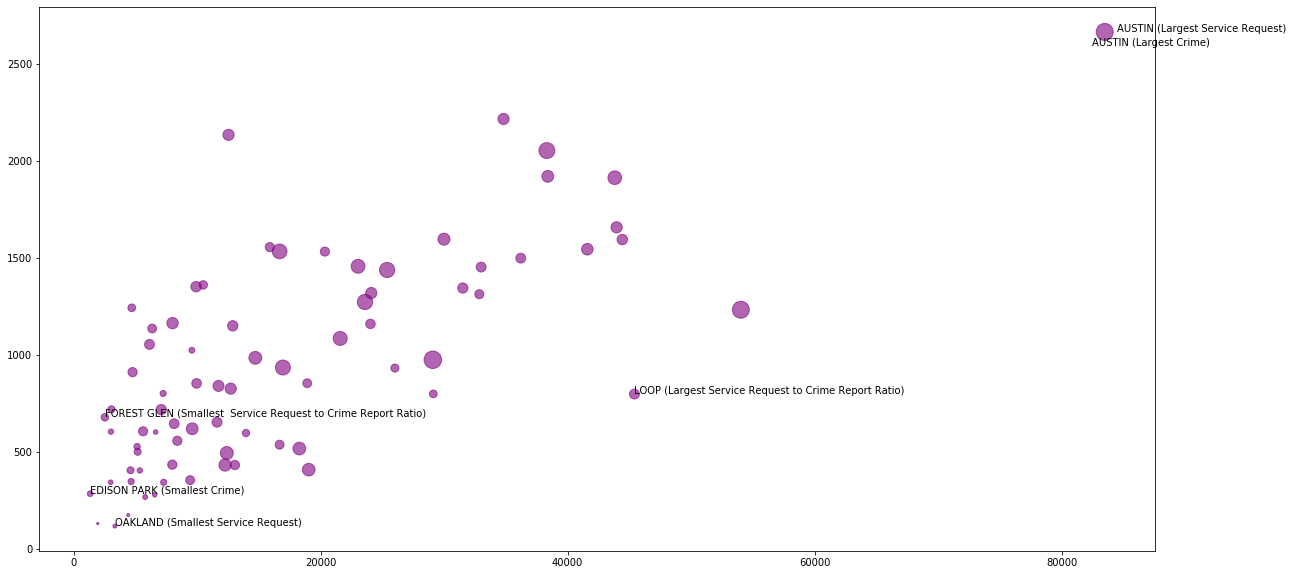

In [74]:
#community areas by crime by street

x=bycomm_pop['ID']
y=bycomm_pop['Service Request Number']
z=bycomm_pop['Community']
w=bycomm_pop['No. of Service Requests to Crime Reports']

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x,y,s=bycomm_pop['Total Population']*.003,c='purple',alpha=0.6)

#Street light request data
y_max=y.max()
y_min=y.min()

i=bycomm_pop.loc[y==y_max, 'ID'].iloc[0]
j=bycomm_pop.loc[y==y_max, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[y==y_max, 'Community'].iloc[0] + " (Largest Service Request)", xy=(i+1000, j))

k=bycomm_pop.loc[y==y_min, 'ID'].iloc[0]
m=bycomm_pop.loc[y==y_min, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[y==y_min, 'Community'].iloc[0] + " (Smallest Service Request)", xy=(k, m))

#Crime numbers
x_max=x.max()
x_min=x.min()

n=bycomm_pop.loc[x==x_max, 'ID'].iloc[0]
p=bycomm_pop.loc[x==x_max, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[x==x_max, 'Community'].iloc[0] + " (Largest Crime)", xy=(n-1000, p-75))

q=bycomm_pop.loc[x==x_min, 'ID'].iloc[0]
r=bycomm_pop.loc[x==x_min, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[x==x_min, 'Community'].iloc[0] + " (Smallest Crime)", xy=(q, r))

#Service Request to Crime ratio
w_max=w.max()
w_min=w.min()

t=bycomm_pop.loc[w==w_max, 'ID'].iloc[0]
u=bycomm_pop.loc[w==w_max, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[w==w_max, 'Community'].iloc[0] + " (Largest Service Request to Crime Report Ratio)", xy=(t, u))

a=bycomm_pop.loc[w==w_min, 'ID'].iloc[0]
b=bycomm_pop.loc[w==w_min, 'Service Request Number'].iloc[0]
print(a)
print(b)
ax.annotate(bycomm_pop.loc[w==w_min, 'Community'].iloc[0] + " (Smallest  Service Request to Crime Report Ratio)", xy=(a, b))

In [75]:
#https://www.kaggle.com/threadid/geopandas-mapping-chicago-crimes 

street_map= gpd.read_file(r'C:\Users\dharti.patel\Desktop\NU_DS_Project1\Street-Lights\Street-Lights\geo_export_f11eb402-3887-43c2-a681-95fde0bf6fbf.shp')

# fig,ax=plt.subplots(figsize=(15,15))
# street_map.plot(ax=ax)

[Text(0.5, 1, 'Street Light Outages 2018')]

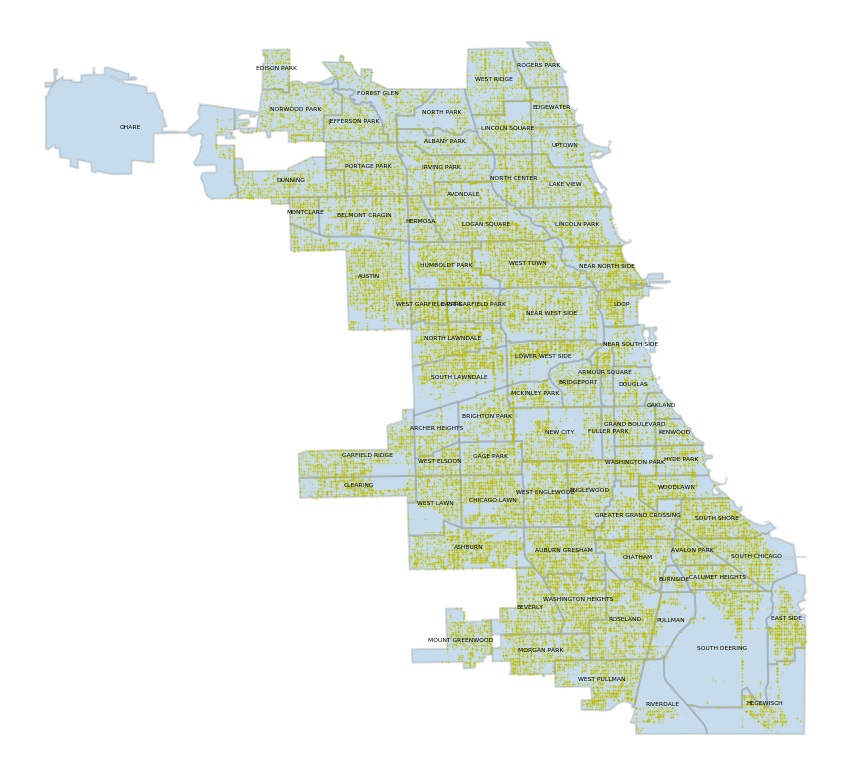

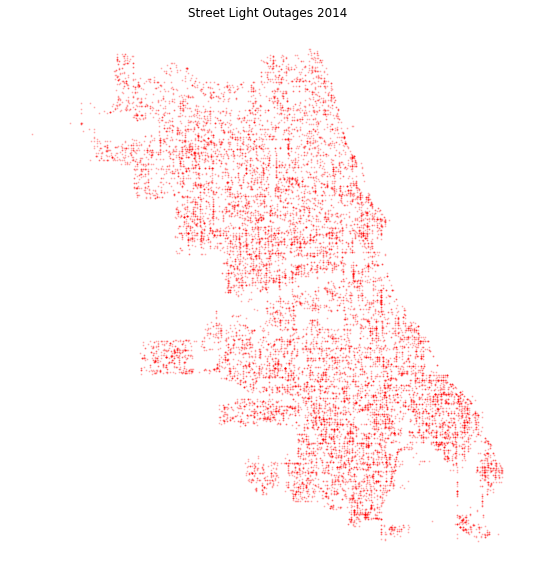

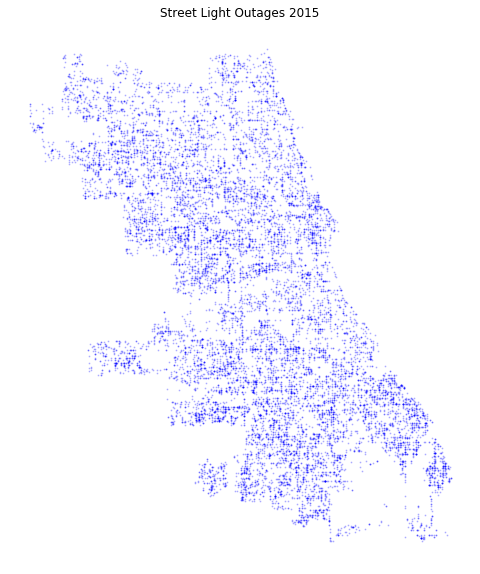

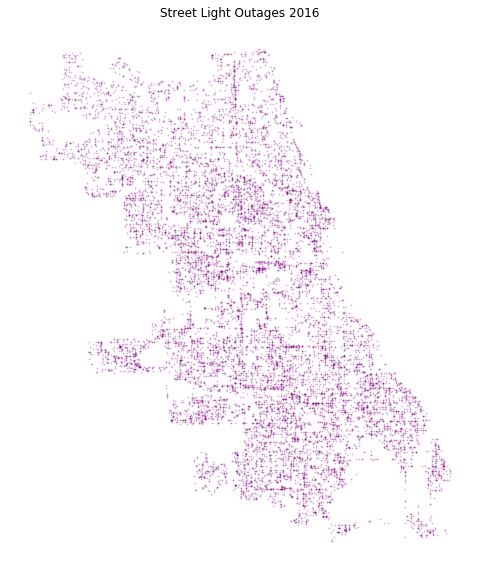

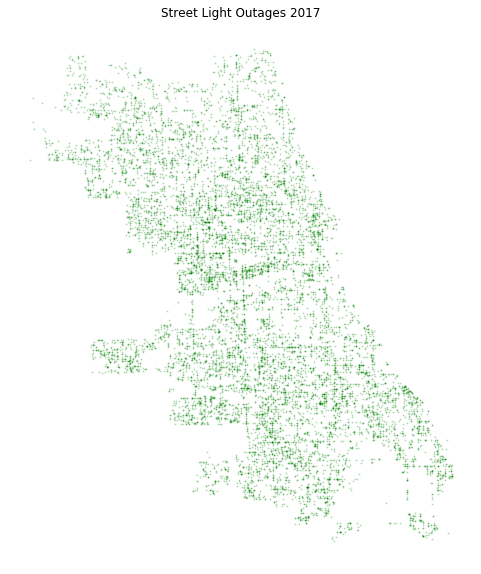

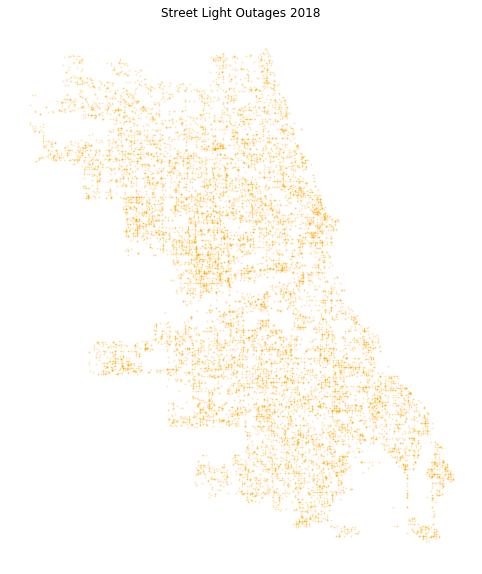

In [76]:
#Street Lights

crs={'init':'epsg:4326'}
street_comm.dtypes
street_comm.head()

geometry= [Point(xy) for xy in zip(street_comm["Longitude"],street_comm["Latitude"])]
geometry[:3]


geo_df=gpd.GeoDataFrame(street_comm,
                       crs=crs,
                       geometry=geometry)
geo_df.head()

# fig.ax=plt.subplots(figsize=(15,15))
# street_map.plot(ax=ax,alpha=0.4,color="grey")
# geo_df[geo_df[geometry]==0].plot(ax=ax,markersize=20,color="blue",marker="o",label="Neg")
# # geo_df[geo_df['WnvPresent']==0].plot(ax=ax,markersize=20,color="red",marker="^",label="Pos")
# # plt.legend(plot={'size':15})

street_loc_df = geo_df.dropna(inplace=False)  # Remove all nan entries. 
street_loc_df = street_loc_df.drop(street_loc_df[(street_loc_df.Latitude < 41.0)].index) #Remove bad values in Long/Lat 
street_loc_df['AREA_NUMBE'] = street_loc_df['AREA_NUMBE'].astype(int)
street_geometry = [Point(xy) for xy in zip(street_loc_df.Longitude, street_loc_df.Latitude)]
# street_geometry = geo_df['geometry']

street_crs = {'type': 'EPSG', 'properties': {'code': 102671}}
street_points = GeoDataFrame(street_loc_df, crs=street_crs, geometry=street_geometry)
street_points.head(5)

# street_map = geo_df.plot(figsize=(25,25), edgecolor='k', facecolor='b', alpha=0.25, linewidth=2) 

#Street lights data
# street_points = street_points.plot(figsize=(10,10), markersize=5) 
# street_points.set_axis_off()

# chistreet_map = street_map.plot(figsize=(25,25), edgecolor='#7f7f7f', cmap='nipy_spectral', alpha=0.5, linewidth=2) 
# street_map.apply(lambda x: chistreet_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=16),axis=1);
# chistreet_map.set_axis_off()

chistreet_map = street_map.plot(figsize=(15,15), edgecolor='#7f7f7f', facecolor='#1f77b4', alpha=0.25, linewidth=2) 
street_map.apply(lambda x: chistreet_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=6),axis=1);
street_points.plot(figsize=(25,25),ax=chistreet_map, markersize=1, color='y', alpha=0.25)
chistreet_map.set_axis_off()

#yearly streetlight visual

# for i in (2014,2015,2016,2017,2018):
#     street_vc_points = street_points.loc[street_points['Year'].isin([i])]

#     street_vc_points_map = street_vc_points.plot(figsize=(5,5), markersize=1, c='blue', alpha=0.2) 
#     street_vc_points_map.set_axis_off()
#     street_vc_points_map.set(title=i)
    
#yearly streetlight visual

street_vc_points = street_points.loc[street_points['Year'].isin(['2014'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='red', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2014')

street_vc_points = street_points.loc[street_points['Year'].isin(['2015'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='blue', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2015')

street_vc_points = street_points.loc[street_points['Year'].isin(['2016'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='purple', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2016')

street_vc_points = street_points.loc[street_points['Year'].isin(['2017'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='green', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2017')

street_vc_points = street_points.loc[street_points['Year'].isin(['2018'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='orange', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2018')



In [159]:
# Crime maps

crime_comm['Primary Type'].unique()

crime_comm_type=crime_comm.loc[crime_comm['Primary Type']=='BATTERY']




crs={'init':'epsg:4326'}
crime_comm_type.dtypes
crime_comm_type.head()

geometry= [Point(xy) for xy in zip(crime_comm_type["Longitude"],crime_comm_type["Latitude"])]
geometry[:3]


geo_df=gpd.GeoDataFrame(crime_comm_type,
                       crs=crs,
                       geometry=geometry)
geo_df.head()

# fig.ax=plt.subplots(figsize=(15,15))
# crime_map.plot(ax=ax,alpha=0.4,color="grey")
# geo_df[geo_df[geometry]==0].plot(ax=ax,markersize=20,color="blue",marker="o",label="Neg")
# # geo_df[geo_df['WnvPresent']==0].plot(ax=ax,markersize=20,color="red",marker="^",label="Pos")
# # plt.legend(plot={'size':15})

crime_loc_df = geo_df.dropna(inplace=False)  # Remove all nan entries. 
crime_loc_df = crime_loc_df.drop(crime_loc_df[(crime_loc_df.Latitude < 41.0)].index) #Remove bad values in Long/Lat 
crime_loc_df['AREA_NUMBE'] = crime_loc_df['AREA_NUMBE'].astype(int)
crime_geometry = [Point(xy) for xy in zip(crime_loc_df.Longitude, crime_loc_df.Latitude)]
# crime_geometry = geo_df['geometry']

crime_crs = {'type': 'EPSG', 'properties': {'code': 102671}}
crime_points = GeoDataFrame(crime_loc_df, crs=crime_crs, geometry=crime_geometry)
crime_points.head(5)

# crime_map = geo_df.plot(figsize=(25,25), edgecolor='k', facecolor='b', alpha=0.25, linewidth=2) 

#crime lights data
# crime_points = crime_points.plot(figsize=(10,10), markersize=5) 
# crime_points.set_axis_off()

# chicrime_map = crime_map.plot(figsize=(25,25), edgecolor='#7f7f7f', cmap='nipy_spectral', alpha=0.5, linewidth=2) 
# crime_map.apply(lambda x: chicrime_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=16),axis=1);
# chicrime_map.set_axis_off()

chicrime_map = street_map.plot(figsize=(15,15), edgecolor='#7f7f7f', facecolor='#1f77b4', alpha=0.25, linewidth=2) 
street_map.apply(lambda x: chicrime_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=6),axis=1);
crime_points.plot(figsize=(25,25),ax=chicrime_map, markersize=1, color='r', alpha=0.25)
chicrime_map.set_axis_off()

#yearly streetlight visual

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2014'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='red', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2014)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2015'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='blue', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2015)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2016'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='purple', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2016)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2017'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='green', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2017)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2018'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='orange', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2018)')